<h1><center>CMPE 462 - Project 1<br>Binary Classification with Logistic Regression<br>Due: April 23, 2020, 23:59</center></h1>

* **Student ID1: 2015400069**
* **Student ID2: 2015400177**
* **Student ID3: 2019700087**

# Overview

In this project, you are going to implement logistic regression from scratch. You are provided
a subset of the famous handwritten digit dataset called MNIST. In the subset, you will find images of digit 1 and 5. Therefore, you will be solving a binary classification problem. The project includes feature extraction, model training, and evaluation steps.

First, you will load and visualize the data portion we have provided to you and then extract two different set of features to build a classifier on. When you extracted the desired features, you will run your logistic regression implementation with gradient descent on the representations to classify digits into 1 and 5. You will experiment with different learning rates  and regularization parameter ($\lambda$) and find the optimal $\lambda$ with 5-fold cross validation. Finally, you will evaluate the implemented models, decide which is the best performing one and visualize a decision boundary.

Follow the steps on this notebook that would guide you through the solution step-by-step. Make sure that the notebook reports your work properly and add comments and opinions when necessary.

**IMPORTANT NOTE:** You are allowed to use third-party libraries such as `numpy` and `matplotlib` to help you implement necessary procedures. However, you should not import any function that accomplishes the task itself. For instance, you can use `numpy` arrays for matrix operations, but you cannot use `scikit-learn` to implement cross validation.

## Task 1: Feature Extraction (35 Pts)

Load the training/test data and labels as numpy arrays (Hint:`np.load`). Train and test data are 1561x256 and 424x256 dimensional matrices, respectively. Each row in the
aforementioned matrices corresponds to an image of a digit. The 256 pixels correspond to a 16x16 image. Label 1 is assigned to digit 1 and label -1 is assigned to digit 5.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def load_files(path):
  return np.load(path)

train_labels = load_files('train_labels.npy')
train_data = load_files('train_data.npy')
test_labels = load_files('test_labels.npy')
test_data = load_files('test_data.npy')

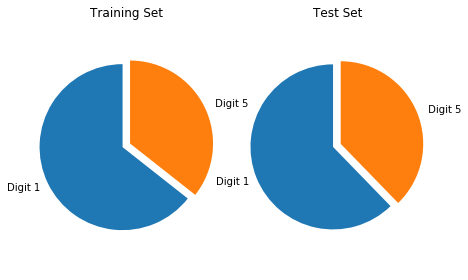

In [0]:
labels = ['Digit 1',' Digit 5']
sizes_train = [np.where(train_labels == 1)[0].shape[0], np.where(train_labels == -1)[0].shape[0]]
sizes_test = [np.where(test_labels == 1)[0].shape[0], np.where(test_labels == -1)[0].shape[0]]
explode = (0.1,0)

fig1, ax = plt.subplots(1,2)

ax[0].pie(sizes_train, explode = explode,labels=labels, startangle=90)
ax[0].axis('equal')
ax[0].set_title('Training Set')

ax[1].pie(sizes_test, explode = explode,labels=labels, startangle=90)
ax[1].axis('equal')
ax[1].set_title('Test Set')

plt.tight_layout()
plt.show()

**(5 points)** Display two of the digit images, one for digit 1 and one for digit 5. You can use `imshow` function of `matplotlib` library with a suitable colormap. You will first need to reshape 256 pixels to a 16x16 matrix. 

Text(0.5,1,'Five(5)')

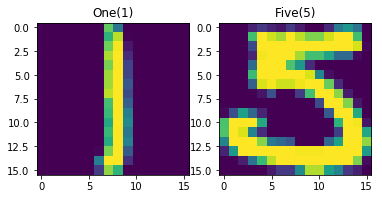

In [0]:

train_data = train_data.reshape(train_data.shape[0], 16, 16)

one_index = np.where(train_labels == 1)[0][0]
five_index = np.where(train_labels == -1)[0][0]

plt.subplot(1, 2, 1)
plt.imshow(train_data[one_index])
plt.title('One(1)')

plt.subplot(1, 2, 2)
plt.imshow(train_data[five_index])
plt.title('Five(5)')

**(10 points) Implementing Representation 1:** Extract the **symmetry** and **average intensity** features discussed in the class (see logistic regression lecture notes). To compute the intensity features, compute the average pixel value of the image, and for the symmetry feature, compute the negative of the norm of the difference between the image and its y-axis symmetrical. Search numpy's documentation to find the suitable function at each step. You should extract these two features for each image in the training and test sets. As a result, you should obtain a training data matrix of size 1561x2 and test data matrix of size 424x2.


Throughout the notebook, we will refer the representation with these two features as **Representation 1** 

In [0]:
def find_average(row):
  return np.mean(row)

def find_symmetry_y(row):
  differences = [(abs(row[i][j] - row[i][15 - j])) for i in range(16) for j in range(16)]
  return -1 * np.mean(differences)

def extract_features_rep1(data):  
  features = np.zeros((len(data), 2))

  for idx, row in enumerate(data):
    row = row.reshape(16, 16)
    features[idx] = [find_average(row), find_symmetry_y(row)]

  return features

def shuffle(data, labels):
  randomize = np.arange(len(data))
  np.random.shuffle(randomize)
  return data[randomize], labels[randomize]

train_data, train_labels = shuffle(train_data, train_labels)

train_features_rep1 = extract_features_rep1(train_data)
test_features_rep1 = extract_features_rep1(test_data)

**(5 points)** Provide two scatter plots, one for training and one for test data. The plots should contain the average intensity values in the x-axis and symmetry values in the
y-axis. Denote the data points of label 1 with blue marker shaped <font color='blue'>o</font> and the data points of label -1 with a red marker shaped <font color='red'>x</font>. (Hint: check out `plt.scatter` and its `marker` and `color` parameters). Explicitly state the axis labels and figure title for both plots (Hint: `plt.xlabel`, `plt.ylabel`, `plt.title`). 

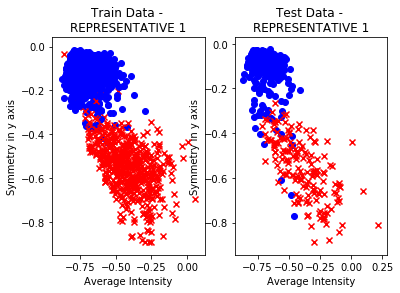

In [0]:
def plot_scatters(train, features, weight, rep, xlabel = 'Average Intensity', ylabel = 'Symmetry in y axis'):
  labels, title, index = (train_labels, 'Train Data', 1) if train is True else (test_labels, 'Test Data', 2)
  title = title + " - " + rep
  plt.subplot(1, 2, index)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)

  for idx, feature in enumerate(features):
      plt.scatter(feature[0], feature[1], c = 'blue' if labels[idx] == 1 else 'red', marker = 'o' if labels[idx] == 1 else 'x')
  
  if weight is not None:
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = -(x_vals * weight[1]+ weight[0])/weight[2]
    plt.plot(x_vals, y_vals, '--', c ="black")

plot_scatters(True, train_features_rep1, None, "\nREPRESENTATIVE 1")
plot_scatters(False, test_features_rep1, None, "\nREPRESENTATIVE 1")

**(15 points) Implementing Representation 2:** Come up with an alternative feature extraction approach. The features can again be 2-D, or higher dimensional. If you use any external resource, please cite the references. Explain the feature extraction procedure clearly in your report; if it is an algorithm, provide the algorithm; if it is a function, provide the mathematical expressions. 

If your proposed features are 2-D or 3-D, provide the scatter plots similar to the previous step.

We will refer this representation proposed by you as **Representation 2**.

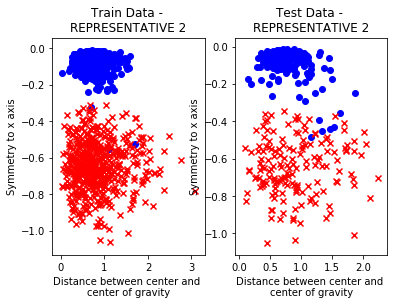

In [0]:
def dist(row):
  counter = 0
  x = 0.0
  y = 0.0
  for i in range(0, 16):
    for j in range(0, 16):
      elem = row[i][j]
      if(elem > -1):
        counter = counter + 1
        x = x + j
        y = y + i

  return ((x / counter - 8)**2 + (y / counter - 8)**2)**0.5

def find_symmetry_x(row):
  differences = [(abs(row[i][j] - row[15 - i][j])) for i in range(16) for j in range(16)]
  return -1 * np.mean(differences) 

def extract_features_rep2(data):  
  features = np.zeros((len(data), 2))

  for idx, row in enumerate(data):
    row = row.reshape(16, 16)
    features[idx] = [dist(row), find_symmetry_x(row)]

  return features

train_features_rep2 = extract_features_rep2(train_data)
test_features_rep2 = extract_features_rep2(test_data)

plot_scatters(True, train_features_rep2, None, "\nREPRESENTATIVE 2", 'Distance between center and \ncenter of gravity', 'Symmetry to x axis')
plot_scatters(False, test_features_rep2, None, "\nREPRESENTATIVE 2", 'Distance between center and \ncenter of gravity', 'Symmetry to x axis')

## Task 2: Logistic Regression (40 Pts)

**(20 points)** Implement the logistic regression classifier from scratch with gradient descent and train it using Representation 1 and Representation 2 as inputs. Concatenate
1 to your features for the intercept term, such that one data point will look like for 2-D features [1,$x_1$,$x_2$], and the model vector will be [$w_0, w_1, w_2$], where $w_0$ is the intercept parameter. 
You can refer to lecture notes (Logistic regression slides 29-30) to review the gradient descent learning algorithm and the logistic loss. To implement the gradient of the logistic loss with respect to $w$, first derive its expression by hand. Please include your derivation in your report.

To prove that your implementation is converging, keep the loss values at each gradient descent iteration in a numpy array. After the training is finalized, plot the loss values
with respect to iteration count (Hint: `plt.plot`). You should observe a decreasing loss as the number of iterations increases. Also, experiment with 5 different learning rates between 0 and 1, and plot the convergence curves for each learning rate in the same plot to observe the effect of the learning rate (step size) on the convergence. 

To decide when to terminate the gradient descent iterations, check the absolute difference between the current loss value and the loss value of the previous step. If the difference is less than a small number, such as $10^{-5}$, you can exit the loop.

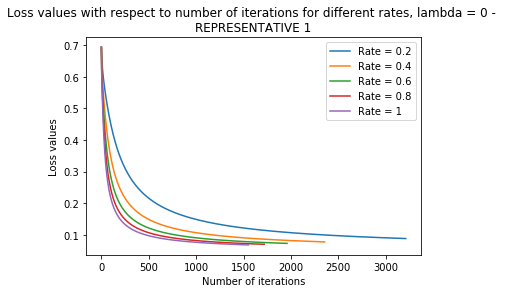

In [0]:
def add_intercept(features):
  return np.insert(features, 0, values = 1, axis = 1)

def sigmoid(value):
  return 1 / (1 + np.exp(-1 * value))

def calculate_loss(h, train_labels, W, lambda_):
  loss = np.log(1 + np.exp(-train_labels*h)).mean()
  regularization = lambda_ * sum(W**2) 
  return loss + regularization

def calculate_gradient(labels, features, W, lambda_):
  return np.mean(-(features * labels[:, np.newaxis]) * (sigmoid(-labels * np.dot(features, W)))[:, np.newaxis], axis = 0) + 2*lambda_*W

def plot_loss_versus_iteration(losses, rate, lambda_ ,title):
  plt.plot(np.arange(0, len(losses)), losses, label = 'Rate = ' + str(rate)) 
  plt.xlabel('Number of iterations')
  plt.ylabel('Loss values')
  plt.title('Loss values with respect to number of iterations for different rates, lambda = ' + str(lambda_) + ' - ' + title)
  plt.legend(loc = 'best')

def train(features, labels, rate, lambda_ = 0):
  W = np.zeros(features.shape[1])
  losses = []
  while True:
    gradient = calculate_gradient(labels, features, W, lambda_)
    curr_loss = calculate_loss(np.dot(features, W), labels, W, lambda_)
    losses.append(curr_loss)
    W = W - rate * gradient
    if(len(losses) > 1 and abs(losses[-2] - losses[-1]) < 10**-5):
      break
  
  return W, losses

def train_init(features, labels, title):
  X = add_intercept(features)
  learning_rates = [0.2, 0.4, 0.6, 0.8, 1]
  best_learning_rate = learning_rates[0]
  loss_length = 100000
  for idx, rate in enumerate(learning_rates):
    weight, loss = train(X, labels, rate)
    plot_loss_versus_iteration(loss, rate, 0, title)
    if(len(loss) < loss_length):
      loss_length = len(loss)
      best_learning_rate = rate
    
  return best_learning_rate

best_learning_rate_rep1 = train_init(train_features_rep1, train_labels, '\nREPRESENTATIVE 1')

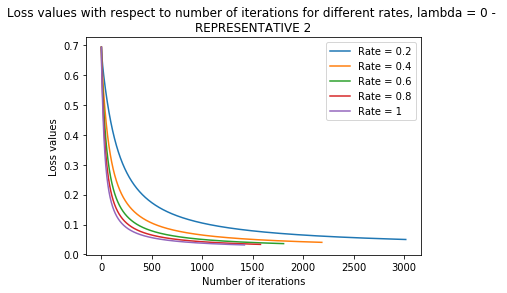

In [0]:
best_learning_rate_rep2 = train_init(train_features_rep2, train_labels, '\nREPRESENTATIVE 2')

**(10 points)** Implement logistic regression with $\ell_2$ norm regularization, $||\mathbf{w}||_{2}^{2}$ . Show that your implementation is working by visualizing the loss over the iterations again. Visualization for a single learning rate and $\lambda$ suffices. 

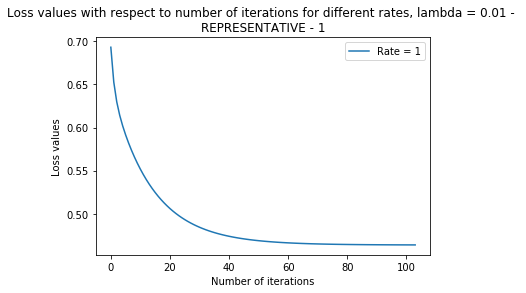

In [0]:
X = add_intercept(train_features_rep1)
weight, loss = train(X, train_labels, best_learning_rate_rep1, lambda_ = 0.01)
plot_loss_versus_iteration(loss, best_learning_rate_rep1, 0.01 ,"\nREPRESENTATIVE - 1")

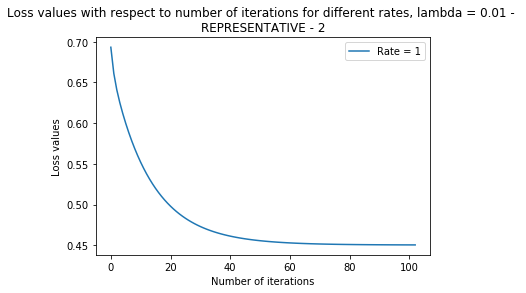

In [0]:
X = add_intercept(train_features_rep2)
weight, loss = train(X, train_labels, best_learning_rate_rep2, lambda_ = 0.01)
plot_loss_versus_iteration(loss, best_learning_rate_rep2, 0.01, "\nREPRESENTATIVE - 2")

**(10 points)** Implement a 5-fold cross validation procedure to find the optimal $\lambda$ value for both Representation 1 and 2. Experiment with at least three different $\lambda$ values between 0 and 1. Report the mean/std of cross validation accuracy of every representation/parameter combination as a table and clearly mark the best configuration in your report. 

In [0]:
fold = 5
def make_split(X, k):
  global fold
  splitted_set = np.split(X[:-1],fold) # 1 data is discarded to make it divideble with 5
  splitted_labels = np.split(train_labels[:-1],fold)
  validation_set = splitted_set[k]
  validation_set_labels = splitted_labels[k]
  isSplit = False

  for i in range(k):
    if not isSplit:
      train_set = splitted_set[i]
      train_set_labels = splitted_labels[i]
      isSplit = True
    else:
      train_set = np.vstack((train_set,splitted_set[i]))
      train_set_labels = np.hstack((train_set_labels,splitted_labels[i]))
  for i in range(k+1,len(splitted_set)):
    if not isSplit:
      train_set = splitted_set[i]
      train_set_labels = splitted_labels[i]
      isSplit = True
    else:
      train_set = np.vstack((train_set,splitted_set[i]))
      train_set_labels = np.hstack((train_set_labels,splitted_labels[i]))

  return train_set, validation_set, train_set_labels, validation_set_labels

def calculate_accuracy(predictions, labels):
  preds = [1 if pred == 1 else -1 for pred in predictions]
  return float(np.sum(preds==labels)) / len(labels)

def cross_validation(features, title):
  print("Calculating for: " + title)
  lambda_values = [0.001, 0.01, 0.05, 0.1]
  lambda_accuracies = np.empty((len(lambda_values), fold))

  X = add_intercept(features)

  for k in range(fold):
    train_set, validation_set, train_set_labels, validation_set_labels = make_split(X, k)
    for idx, lambda_ in enumerate(lambda_values):
      weight, loss = train(train_set, train_set_labels, 0.2, lambda_)
      h = sigmoid(np.dot(validation_set, weight))
      predictions = (h > 0.5).astype(int)
      accuracy = calculate_accuracy(predictions, validation_set_labels)
      lambda_accuracies[idx][k] = accuracy

  print("Lambda accuracies:")
  print(lambda_accuracies)
  lambda_mean_std = dict()
  for idx,mean_std in enumerate(zip(lambda_accuracies.mean(1), lambda_accuracies.std(1))):
    lambda_mean_std[lambda_values[idx]] = mean_std

  print("Lambda mean, std:")
  print(lambda_mean_std)

  best_lambda = max(lambda_mean_std.items(), key = lambda x: x[1])[0]
  print("Best lambda:")
  print(best_lambda)
  print("\n")
  return best_lambda

best_lambda_rep1 = cross_validation(train_features_rep1, 'REPRESENTATIVE 1')
best_lambda_rep2 = cross_validation(train_features_rep2, 'REPRESENTATIVE 2')

Calculating for: REPRESENTATIVE 1
Lambda accuracies:
[[0.96474359 0.97435897 0.98076923 0.96153846 0.97435897]
 [0.91666667 0.93910256 0.92307692 0.90705128 0.92628205]
 [0.70833333 0.76602564 0.67628205 0.69551282 0.63141026]
 [0.65384615 0.72115385 0.63141026 0.64102564 0.59294872]]
Lambda mean, std:
{0.1: (0.6480769230769231, 0.04180942015159058), 0.001: (0.9711538461538461, 0.007022084070579028), 0.05: (0.6955128205128205, 0.04385290096535148), 0.01: (0.9224358974358975, 0.010610862408491576)}
Best lambda:
0.001


Calculating for: REPRESENTATIVE 2
Lambda accuracies:
[[0.98717949 0.98717949 0.99038462 0.99679487 0.98717949]
 [0.96794872 0.9775641  0.96474359 0.96153846 0.96794872]
 [0.81730769 0.87820513 0.7724359  0.76282051 0.70833333]
 [0.67628205 0.76602564 0.66025641 0.67307692 0.6025641 ]]
Lambda mean, std:
{0.1: (0.6756410256410257, 0.05244671068995582), 0.001: (0.9897435897435898, 0.0037377896761828715), 0.05: (0.7878205128205129, 0.05695396482369531), 0.01: (0.9679487179487

## Task 3: Evaluation (25 Pts)

**(5 points)** Train the logistic regression classifier on Representation 1 and 2 with the best learning rate you decide. Similarly, train the regularized logistic regression classifier with the best $\lambda$ you obtained by 5-fold cross validation. Report the training and test classification accuracy as 
\begin{align*}
\frac{\text{number of correctly classified samples}}{\text{total number of samples}}x100
\end{align*}

In [0]:
def evaluate(features_train, features_test, train_l, test_l, best_learning_rate, best_lambda, title):
  print("Evaluating for " + title + " with lambda = " + str(best_lambda) + "\n")

  X = add_intercept(features_train)
  test = add_intercept(features_test)
  weight, loss = train(X, train_labels, best_learning_rate, best_lambda)

  h = sigmoid(np.dot(X, weight))
  predictions = (h > 0.5).astype(int)
  train_accuracy = calculate_accuracy(predictions, train_l)

  print("Train accuracy is " + str(train_accuracy * 100) +"%")

  h = sigmoid(np.dot(test, weight))
  predictions = (h > 0.5).astype(int)
  test_accuracy = calculate_accuracy(predictions, test_l)

  print("Test accuracy is " + str(test_accuracy * 100) + "%\n")
  return weight, test_accuracy

weight_rep1, accuracy_rep1 = evaluate(train_features_rep1, test_features_rep1, train_labels, test_labels, best_learning_rate_rep1, 0, "REPRESENTATIVE 1")
weight_rep1_reg, accuracy_rep1_reg = evaluate(train_features_rep1, test_features_rep1, train_labels, test_labels, best_learning_rate_rep1, best_lambda_rep1, "REPRESENTATIVE 1")
weight_rep2, accuracy_rep2 = evaluate(train_features_rep2, test_features_rep2, train_labels, test_labels, best_learning_rate_rep2, 0, "\nREPRESENTATIVE 2")
weight_rep2_reg, accuracy_rep2_reg = evaluate(train_features_rep2, test_features_rep2, train_labels, test_labels, best_learning_rate_rep2, best_lambda_rep2, "\nREPRESENTATIVE 2")

w_rep1 = weight_rep1 if accuracy_rep1 > accuracy_rep1_reg else weight_rep1_reg
w_rep2 = weight_rep2 if accuracy_rep2 > accuracy_rep2_reg else weight_rep2_reg

Evaluating for REPRESENTATIVE 1 with lambda = 0

Train accuracy is 97.9500320307%
Test accuracy is 96.2264150943%

Evaluating for REPRESENTATIVE 1 with lambda = 0.001

Train accuracy is 97.3734785394%
Test accuracy is 95.0471698113%

Evaluating for 
REPRESENTATIVE 2 with lambda = 0

Train accuracy is 99.6796925048%
Test accuracy is 98.5849056604%

Evaluating for 
REPRESENTATIVE 2 with lambda = 0.001

Train accuracy is 99.1672005125%
Test accuracy is 98.3490566038%



**(15 points)** Visualize the decision boundary (the line that is given by $\mathbf{w}^{T}x=0$) obtained from the logistic regression classifier learned without regularization. For this purpose, use only Representation 1. Provide two scatter plots for training and test data points with the decision boundary shown on each of the plots.

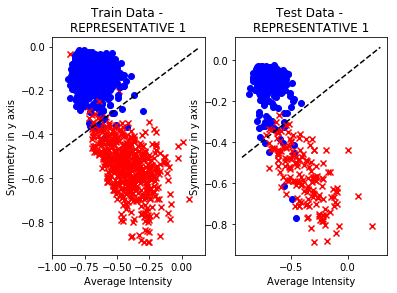

In [0]:
plot_scatters(True, train_features_rep1, w_rep1, '\nREPRESENTATIVE 1')
plot_scatters(False, test_features_rep1, w_rep1, '\nREPRESENTATIVE 1')

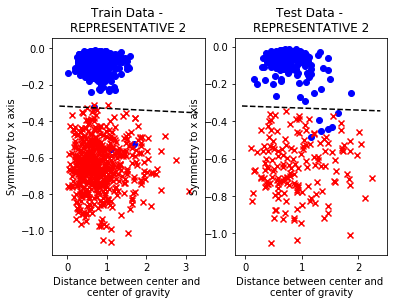

In [0]:
plot_scatters(True, train_features_rep2, w_rep2, '\nREPRESENTATIVE 2', 'Distance between center and \ncenter of gravity', 'Symmetry to x axis')
plot_scatters(False, test_features_rep2, w_rep2, '\nREPRESENTATIVE 2', 'Distance between center and \ncenter of gravity', 'Symmetry to x axis')

**(5 points)** Comment on your work in your report. Include the answers for the following questions in your discussion. 

* Did regularization improve the generalization performance (did it help reducing the gap between training and test accuracies/errors)? Did you observe any difference between using Representation 1 and 2?
* Which feature set did give the best results? Which one is more discriminative?
* What would be your next step to improve test accuracy? 